In [1]:
import pandas as pd
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import norm
from scipy.optimize import minimize_scalar

DATA_DIR = Path("../data")

df_q4 = pd.read_excel(DATA_DIR / "FI.xlsm", sheet_name="Q4", header=2, usecols="E:F")
df_q4.columns = ["Days", "DF"]
df_q4.dropna(inplace=True)

euribor_df = pd.read_excel(DATA_DIR / "FI.xlsm", sheet_name="Historical Euribor", header=4, usecols="A:B")
euribor_df.columns = ["Date", "3M EURIBOR"]
euribor_df["Date"] = pd.to_datetime(euribor_df["Date"])
euribor_df.set_index("Date", inplace=True)
euribor_series = euribor_df["3M EURIBOR"].astype(float) / 100

# QuantLib setup - check documentation on their website - https://quantlib-python-docs.readthedocs.io/en/latest/
valuation_date = ql.Date(26, 11, 2024)
ql.Settings.instance().evaluationDate = valuation_date
ql_dates = [valuation_date + int(d) for d in df_q4["Days"]]
ql_dfs = df_q4["DF"].tolist()
curve = ql.DiscountCurve(ql_dates, ql_dfs, ql.Actual365Fixed(), ql.TARGET())
curve.enableExtrapolation()
curve_handle = ql.YieldTermStructureHandle(curve)

valuation_dt = pd.Timestamp("2024-11-26")

# Bond parameters
notional = 1000
issue_date = ql.Date(29, 7, 2022)
maturity_date = ql.Date(29, 7, 2027)
schedule = ql.Schedule(issue_date, maturity_date, ql.Period("3M"), ql.TARGET(),
                       ql.ModifiedFollowing, ql.ModifiedFollowing,
                       ql.DateGeneration.Forward, False)
floor_rate = 0.016
cap_rate = 0.037
day_count = ql.Actual360()
calendar = ql.TARGET()

# Helpers
def ql_to_datetime(qdate):
    return pd.Timestamp(qdate.year(), qdate.month(), qdate.dayOfMonth())

def get_euribor_fixing(reset_date, start, end):
    try:
        return euribor_series.loc[ql_to_datetime(reset_date)]
    except KeyError:
        return curve_handle.forwardRate(start, end, day_count, ql.Simple).rate()

# Cash flow build
rows = []
for i in range(1, len(schedule)):
    start = schedule[i-1]
    end = schedule[i]
    reset = calendar.advance(start, -2, ql.Days)
    accrual = day_count.yearFraction(start, end)

    ref_rate = get_euribor_fixing(reset, start, end)
    capped_rate = min(max(ref_rate, floor_rate), cap_rate)

    df = 1.0 if end < valuation_date else curve_handle.discount(end)
    coupon = notional * ref_rate * accrual
    capped_coupon = notional * capped_rate * accrual
    
    rows.append([
        ql_to_datetime(start), ql_to_datetime(end), ql_to_datetime(reset),
        round(accrual, 6), round(ref_rate * 100, 4), round(capped_rate * 100, 4),
        round(coupon, 2), round(capped_coupon, 2), round(df, 6),
        round(df * coupon, 2), round(df * capped_coupon, 2)
    ])

columns = ["Start", "End", "Reset", "Accrual", "Euribor Rate (%)", "Cap/Floor Rate (%)",
           "Coupon (€)", "Cap/Floor Coupon (€)", "DF", "PV (€)", "PV Cap/Floor (€)"]
cf_df = pd.DataFrame(rows, columns=columns)

# Calculate accrued interest
for i in range(1, len(cf_df)):
    s = pd.Timestamp(cf_df.loc[i, "Start"])
    e = pd.Timestamp(cf_df.loc[i, "End"])
    if s <= valuation_dt < e:
        accrual_days = (valuation_dt - s).days
        total_days = (e - s).days
        period_rate = cf_df.loc[i, "Cap/Floor Rate (%)"] / 100
        ACCRUED_INTEREST = notional * period_rate * accrual_days / 360
        break

cf_df


,Start,End,Reset,Accrual,Euribor Rate (%),Cap/Floor Rate (%),Coupon (€),Cap/Floor Coupon (€),DF,PV (€),PV Cap/Floor (€)
0,2022-07-29,2022-10-31,2022-07-27,0.261111,0.2380,1.6000,0.62,4.18,1.000000,0.62,4.18
1,2022-10-31,2023-01-30,2022-10-27,0.252778,1.6050,1.6050,4.06,4.06,1.000000,4.06,4.06
2,2023-01-30,2023-04-28,2023-01-26,0.244444,2.4680,2.4680,6.03,6.03,1.000000,6.03,6.03
3,2023-04-28,2023-07-31,2023-04-26,0.261111,3.2420,3.2420,8.47,8.47,1.000000,8.47,8.47
4,2023-07-31,2023-10-30,2023-07-27,0.252778,3.7140,3.7000,9.39,9.35,1.000000,9.39,9.35
5,2023-10-30,2024-01-29,2023-10-26,0.252778,3.9520,3.7000,9.99,9.35,1.000000,9.99,9.35
6,2024-01-29,2024-04-29,2024-01-25,0.252778,3.9250,3.7000,9.92,9.35,1.000000,9.92,9.35
7,2024-04-29,2024-07-29,2024-04-25,0.252778,3.8640,3.7000,9.77,9.35,1.000000,9.77,9.35
8,2024-07-29,2024-10-29,2024-07-25,0.255556,3.6860,3.6860,9.42,9.42,1.000000,9.42,9.42
9,2024-10-29,2025-01-29,2024-10-25,0.255556,3.0590,3.0590,7.82,7.82,0.994724,7.78,7.78


In [2]:
# Best and worst-case scenario valuations
best_case_rate = cap_rate
worst_case_rate = floor_rate

best_rows = []
worst_rows = []

for i in range(1, len(schedule)):
    start = schedule[i - 1]
    end = schedule[i]
    accrual = day_count.yearFraction(start, end)
    
    # Do not include paid coupons
    if end < valuation_date:
        continue

    df = curve_handle.discount(end)

    # Best-case: always cap rate
    best_coupon = notional * best_case_rate * accrual
    best_pv = best_coupon * df
    best_rows.append([ql_to_datetime(start), ql_to_datetime(end), round(accrual, 6),
                      round(best_case_rate * 100, 4), round(best_coupon, 2), round(df, 6), round(best_pv, 2)])

    # Worst-case: always floor rate
    worst_coupon = notional * worst_case_rate * accrual
    worst_pv = worst_coupon * df
    worst_rows.append([ql_to_datetime(start), ql_to_datetime(end), round(accrual, 6),
                       round(worst_case_rate * 100, 4), round(worst_coupon, 2), round(df, 6), round(worst_pv, 2)])

# Build DataFrames
columns_case = ["Start", "End", "Accrual", "Rate (%)", "Coupon (€)", "DF", "PV (€)"]
best_df = pd.DataFrame(best_rows, columns=columns_case)
worst_df = pd.DataFrame(worst_rows, columns=columns_case)

# Total PVs
pv_notional = notional * curve_handle.discount(schedule[-1])
best_pv_coupon = best_df["PV (€)"].sum()
worst_pv_coupon = worst_df["PV (€)"].sum()

print(f" Best-case Cupon PV: €{best_pv_coupon:.2f}")
print(f" Worst-case Coupon PV: €{worst_pv_coupon:.2f}")
print(f' PV Notional: €{pv_notional:.2f}')
print(f" Best-case Gross Value: €{(best_pv_coupon+pv_notional+ACCRUED_INTEREST):.2f}")
print(f" Worst-case Gross Value: €{(worst_pv_coupon+pv_notional+ACCRUED_INTEREST):.2f}")

 Best-case Cupon PV: €99.82
 Worst-case Coupon PV: €43.17
 PV Notional: €943.54
 Best-case Gross Value: €1045.74
 Worst-case Gross Value: €989.09


In [3]:
# Calibrate and price caplets/floorlets using Shifted Black model - need to explain why this model 
# MCVA 
# Prices
caplet_vols = {
    1: 0.1566,
    2: 0.1621,
    3: 0.1641,
    4: 0.1684,
    5: 0.1738
}

shift = 0.03  # Shift used in market quotes
R = 0.40      # Recovery rate
cds = 0.004921  # Flat CDS spread

option_rows = []
future_cf = cf_df[cf_df["End"] > valuation_dt].copy().sort_values("End").reset_index(drop=True)

# Survival probability Q(t, T)
def Q(tau, cds, R):
    return (np.exp(-cds * tau) - R) / (1 - R)

# Initial conditions
tau_prev = 0
Q_prev = 1

pv_survival_total = 0
pv_default_total = 0
notional_survival = 0

for i, row in future_cf.iterrows():
    start = ql.Date(row["Start"].day, row["Start"].month, row["Start"].year)
    end = ql.Date(row["End"].day, row["End"].month, row["End"].year)

    if start < valuation_date:
        continue

    accrual = day_count.yearFraction(start, end)
    ttm = day_count.yearFraction(valuation_date, end)
    df = curve_handle.discount(end)
    forward_rate = (curve_handle.discount(start) / df - 1) / accrual

    year_bucket = min(int(np.ceil(ttm)), 5)
    vol = caplet_vols[year_bucket]

    fwd_shifted = forward_rate + shift
    cap_price = ql.blackFormula(
        ql.Option.Call, cap_rate + shift, fwd_shifted,
        vol * np.sqrt(ttm), df * accrual * notional
    )
    floor_price = ql.blackFormula(
        ql.Option.Put, floor_rate + shift, fwd_shifted,
        vol * np.sqrt(ttm), df * accrual * notional
    )

    effective_rate = min(max(forward_rate, floor_rate), cap_rate)
    net_coupon = notional * accrual * effective_rate
    cap_pv = cap_price * df
    floor_pv = floor_price * df

    tau = (row["End"] - valuation_dt).days / 365.0
    Q_curr = Q(tau, cds, R)
    dQ = Q_prev - Q_curr
    #Default value: assume full notional exposure at each node
    #exposure = notional + net_coupon
    # Full exposure only at maturity 
    exposure = notional + net_coupon if i == len(future_cf) - 1 else net_coupon
    # see e.g. O’Kane, Brigo & Capponi

    pv_surv = Q_curr * df * net_coupon
    pv_def = dQ * df * exposure * R

    pv_survival_total += pv_surv
    pv_default_total += pv_def

    if i == len(future_cf) - 1:
        notional_survival = Q_curr * df * notional

    option_rows.append([
        row["Start"], row["End"], round(accrual, 6), round(ttm, 4),
        round(forward_rate * 100, 4), round(vol * 100, 2),
        round(cap_rate * 100, 2), round(floor_rate * 100, 2),
        round(cap_price, 4), round(floor_price, 4),
        round(net_coupon, 4), round(df, 6),
        f"{Q_curr * 100:.2f}%", round(pv_surv, 4),
        round(dQ, 6), round(pv_def, 4)
    ])

    Q_prev = Q_curr
    tau_prev = tau

# Risk-free and risky pricing
df_n = curve_handle.discount(ql.Date(29, 7, 2027))
pv_option_cf = sum([r[10] for r in option_rows])

risk_free_gross_value = pv_option_cf + notional * df_n
risky_gross_value = pv_survival_total + pv_default_total + notional_survival
cva = risk_free_gross_value - risky_gross_value

clean_price_risk_free = risk_free_gross_value - ACCRUED_INTEREST
clean_price_risky = risky_gross_value - ACCRUED_INTEREST

# Output as DataFrame
option_cols = [
    "Start", "End", "Accrual", "TTM", "Fwd Rate (%)", "Volatility (%)",
    "Cap Strike (%)", "Floor Strike (%)",
    "Caplet Price (€)", "Floorlet Price (€)", "Exp. Coupon (€)",
    "DF", "Survival Prob.", "PV(CF) on Survival (€)", "ΔQ", "PV on Default (€)"
]

option_df = pd.DataFrame(option_rows, columns=option_cols)

# Summary
print(f"Option-Based Pricing Summary:")
print(f"\nPV of Expected Coupons (Option-based): €{pv_option_cf:.2f}")
print(f"PV of Notional: €{notional * df_n:.2f}")
print(f"\nPV Coupons on Survival: €{pv_survival_total:.2f}")
print(f"PV Notional on Survival: €{notional_survival:.2f}")
print(f"PV Cash Flow on Default: €{pv_default_total:.2f}")
print(f"\nBond Risk-Free Gross Price: €{risk_free_gross_value:.2f}")
print(f"Bond Risky-adjusted Gross Price: €{risky_gross_value:.2f}")
print(f"Bond Risk-free Clean Price: €{clean_price_risk_free:.2f}")
print(f"Bond Risky-adjusted Clean Price: €{clean_price_risky:.2f}")
print(f"CVA: €{cva:.2f}")

display(option_df)

Option-Based Pricing Summary:

PV of Expected Coupons (Option-based): €52.97
PV of Notional: €943.54

PV Coupons on Survival: €50.56
PV Notional on Survival: €923.00
PV Cash Flow on Default: €0.81

Bond Risk-Free Gross Price: €996.51
Bond Risky-adjusted Gross Price: €974.36
Bond Risk-free Clean Price: €994.13
Bond Risky-adjusted Clean Price: €971.99
CVA: €22.14


,Start,End,Accrual,TTM,Fwd Rate (%),Volatility (%),Cap Strike (%),Floor Strike (%),Caplet Price (€),Floorlet Price (€),Exp. Coupon (€),DF,Survival Prob.,PV(CF) on Survival (€),ΔQ,PV on Default (€)
0,2025-01-29,2025-04-29,0.250000,0.4278,2.6124,15.66,3.7,1.6,0.0264,0.0127,6.5310,0.988269,99.65%,6.4321,0.003457,0.0089
1,2025-04-29,2025-07-29,0.252778,0.6806,2.4804,15.66,3.7,1.6,0.0501,0.0650,6.2700,0.982112,99.45%,6.1240,0.002039,0.0050
2,2025-07-29,2025-10-29,0.255556,0.9361,1.7927,15.66,3.7,1.6,0.0101,0.4936,4.5814,0.977633,99.24%,4.4451,0.002059,0.0037
3,2025-10-29,2026-01-29,0.255556,1.1917,1.8079,16.21,3.7,1.6,0.0293,0.5918,4.6202,0.973137,99.04%,4.4529,0.002057,0.0037
4,2026-01-29,2026-04-29,0.250000,1.4417,1.9774,16.21,3.7,1.6,0.0747,0.5144,4.9436,0.968349,98.84%,4.7315,0.002009,0.0038
5,2026-04-29,2026-07-29,0.252778,1.6944,1.9775,16.21,3.7,1.6,0.1064,0.5877,4.9986,0.963533,98.63%,4.7506,0.002029,0.0039
6,2026-07-29,2026-10-29,0.255556,1.9500,1.9775,16.21,3.7,1.6,0.1412,0.6580,5.0537,0.958688,98.43%,4.7689,0.002049,0.0040
7,2026-10-29,2027-01-29,0.255556,2.2056,2.0750,16.41,3.7,1.6,0.2184,0.6558,5.3027,0.953631,98.23%,4.9671,0.002047,0.0041
8,2027-01-29,2027-04-29,0.250000,2.4556,2.1220,16.41,3.7,1.6,0.2719,0.6613,5.3050,0.948599,98.03%,4.9330,0.002000,0.0040
9,2027-04-29,2027-07-29,0.252778,2.7083,2.1221,16.41,3.7,1.6,0.3159,0.7194,5.3641,0.943538,97.82%,4.9511,0.002019,0.7662


In [4]:
# EuroTLX quoted clean price on 18 Nov 2024
quoted_clean_price_pct = 98.43
market_clean_price = quoted_clean_price_pct / 100 * notional

# Survival Probability Function
def Q(tau, cds_spread, recovery):
    return (np.exp(-cds_spread * tau) - recovery) / (1 - recovery)

# Compute Model Clean Price from a CDS guess
def compute_model_clean_price(cds_guess):
    Q_prev = 1.0
    pv_survival_total = 0.0
    pv_default_total = 0.0
    notional_survival = 0.0

    for i, row in future_cf.iterrows():
        payment_date = row["End"]
        coupon_cash_flow = row["Cap/Floor Coupon (€)"]
        df = row["DF"]

        tau = (payment_date - valuation_dt).days / 365.0
        Q_curr = Q(tau, cds_guess, R)
        dQ = Q_prev - Q_curr

        # Exposure = full notional only at maturity
        exposure = notional + coupon_cash_flow if i == len(future_cf) - 1 else coupon_cash_flow

        pv_survival_total += Q_curr * df * coupon_cash_flow
        pv_default_total += dQ * df * exposure * R

        if i == len(future_cf) - 1:
            notional_survival = Q_curr * df * notional

        Q_prev = Q_curr

    # Total risky value (survival + recovery)
    risky_value = pv_survival_total + notional_survival + pv_default_total
    clean_price = risky_value - ACCRUED_INTEREST
    return clean_price

# Objective: minimize difference vs. market clean price
def cds_objective(cds_guess):
    return abs(compute_model_clean_price(cds_guess) - market_clean_price)

# optimization to find implied CDS
result = minimize_scalar(cds_objective, bounds=(0.0001, 0.10), method='bounded')
implied_cds = result.x
implied_cds_bps = round(implied_cds * 10000, 2)
implied_model_price = compute_model_clean_price(implied_cds)
price_diff = implied_model_price - market_clean_price


comparison_table = pd.DataFrame({
    "Metric": [
        "EuroTLX Quoted Clean Price (18-Nov-2024)",
        "Model Clean Price (Risk-Free)",
        "Model Clean Price (Marginal CVA)",
        "Model Clean Price (After Market-Implied CDS)",
        "Quoted CDS Level (Bloomberg, 5Y)",
        "Market-Implied CDS Spread (Flat)",
        "",
        "Accrued Interest",
        "Risk-Free Gross Price",
        "Risky Gross Price (w/ CVA)",
        "Model CVA (Risk-Free - Risky)"
    ],
    "Value": [
        f"{market_clean_price:.2f}€",
        f"{clean_price_risk_free:.2f}€",
        f"{clean_price_risky:.2f}€",
        f"{implied_model_price:.2f}€",
        "49.21 bps",
        f"{implied_cds_bps} bps",
        "",
        f"{ACCRUED_INTEREST:.2f}€",
        f"{risk_free_gross_value:.2f}€",
        f"{risky_gross_value:.2f}€",
        f"{cva:.2f}€"
    ]
})

display(comparison_table)

,Metric,Value
0,EuroTLX Quoted Clean Price (18-Nov-2024),984.30€
1,Model Clean Price (Risk-Free),994.13€
2,Model Clean Price (Marginal CVA),971.99€
3,Model Clean Price (After Market-Implied CDS),984.29€
4,"Quoted CDS Level (Bloomberg, 5Y)",49.21 bps
5,Market-Implied CDS Spread (Flat),38.34 bps
6,,
7,Accrued Interest,2.38€
8,Risk-Free Gross Price,996.51€
9,Risky Gross Price (w/ CVA),974.36€


In [5]:
# Term Structure Shift Functions

def apply_shift(spot_curve, shift_type, shift):
    # Normalize shift_type to lowercase
    shift_type = shift_type.lower()
    t1 = df_q4['Days'].min()
    tm = df_q4['Days'].median()
    tn = df_q4['Days'].max()
    b = (-shift - shift) / (tn - t1)

    if shift_type == 'parallel':
        return [x + shift for x in spot_curve]

    elif shift_type == 'slope':
        shifts = np.arange(shift, shift + len(spot_curve) * b, b)
        return [x + y for x, y in zip(spot_curve, shifts)]

    elif shift_type == 'convexity':
        X = np.array([[1, 0, 0], [1, tm, tm**2], [1, tn, tn**2]])
        Y = np.array([shift, -shift, shift]).reshape(3, 1)
        beta = np.linalg.inv(X) @ Y
        a, b, c = beta.flatten()
        shifts = [a + b * x + c * x**2 for x in df_q4['Days']]
        return [x + y for x, y in zip(spot_curve, shifts)]
    
    else:
        raise ValueError(f"Unknown shift_type: {shift_type}")

# Bond Pricing with Shifted Discount Curve

def compute_bond_clean_price(dfs):
    ql_dates = [valuation_date + int(d) for d in df_q4["Days"]]
    curve = ql.DiscountCurve(ql_dates, dfs.tolist(), ql.Actual365Fixed(), ql.TARGET())
    curve.enableExtrapolation()
    handle = ql.YieldTermStructureHandle(curve)

    pv = 0.0
    for i, row in future_cf.iterrows():
        qldate = ql.Date(row["End"].day, row["End"].month, row["End"].year)
        pv += row["Cap/Floor Coupon (€)"] * handle.discount(qldate)
        if i == len(future_cf) - 1:
            pv += notional * handle.discount(qldate)
    return pv

# Sensitivity 

def run_term_structure_sensitivity(spot_rate, shift_dict, label=""):
    results = {
        "Shifts": [],
        f"{label} Up Bond (€)": [],
        f"{label} Down Bond (€)": [],
        f"{label} Shift (€)": []
    }

    for shift_type, value in shift_dict.items():
        shift_type_lc = shift_type.lower()
        up_shift = apply_shift(spot_rate, shift_type_lc, value)
        down_shift = apply_shift(spot_rate, shift_type_lc, -value)

        df_up = np.exp(-np.array(up_shift) * df_q4["Days"] / 365)
        df_down = np.exp(-np.array(down_shift) * df_q4["Days"] / 365)

        price_up = compute_bond_clean_price(df_up) + ACCRUED_INTEREST
        price_down = compute_bond_clean_price(df_down) + ACCRUED_INTEREST
        dv01 = -(price_up - price_down) / 2

        results["Shifts"].append(shift_type)
        results[f"{label} Up Bond (€)"].append(price_up)
        results[f"{label} Down Bond (€)"].append(price_down)
        results[f"{label} Shift (€)"].append(dv01)

    return pd.DataFrame(results)

# Parameters 

SPOT_RATE = (-np.log(df_q4['DF']) / (df_q4['Days'] / 365)).fillna(1)
future_cf = cf_df[cf_df["End"] > pd.Timestamp("2024-11-26")].copy().sort_values("End").reset_index(drop=True)

# Shifts: separated for DV01 vs Scenario stress
DV01_SHIFTS = {"Parallel": 0.0001, "Slope": 0.0001, "Convexity": 0.0001}
SCENARIO_SHIFTS = {"Parallel": 0.0002, "Slope": 0.0002, "Convexity": 0.0002}

# Base price
gross_base = compute_bond_clean_price(df_q4["DF"]) + ACCRUED_INTEREST


df_dv01 = run_term_structure_sensitivity(SPOT_RATE, DV01_SHIFTS, label="DV01")
df_scenarios = run_term_structure_sensitivity(SPOT_RATE, SCENARIO_SHIFTS, label="Scenario")


print(f"Initial Gross Risk-Free Bond Value: €{gross_base:.4f}")
display(df_dv01)

print("\nScenario Shift Impact:")
display(df_scenarios)

Initial Gross Risk-Free Bond Value: €1004.9410


,Shifts,DV01 Up Bond (€),DV01 Down Bond (€),DV01 Shift (€)
0,Parallel,1004.681128,1005.200917,0.259895
1,Slope,1004.704028,1005.178006,0.236989
2,Convexity,1004.768675,1005.113332,0.172329



Scenario Shift Impact:


,Shifts,Scenario Up Bond (€),Scenario Down Bond (€),Scenario Shift (€)
0,Parallel,1004.421337,1005.460915,0.519789
1,Slope,1004.467125,1005.415080,0.473977
2,Convexity,1004.596391,1005.285706,0.344657


In [6]:
# CDS Sensitivity 

base_cds = cds  # Already defined as 0.004921 (49.21 bps from investing.com)

cds_shift_range = list(range(-10, 11))  # ±10 bps
cds_levels = [base_cds + bps / 10000 for bps in cds_shift_range]

spread_results = []

def compute_clean_price_cds(cds_spread):
    Q_prev = 1.0
    pv_surv = 0.0
    pv_default = 0.0
    notional_surv = 0.0

    for i, row in future_cf.iterrows():
        end = row["End"]
        cf = row["Cap/Floor Coupon (€)"]
        df = row["DF"]
        tau = (pd.Timestamp(end) - valuation_dt).days / 365.0

        Q_curr = (np.exp(-cds_spread * tau) - R) / (1 - R)
        dQ = Q_prev - Q_curr

        exposure = cf if i != len(future_cf) - 1 else cf + notional

        pv_surv += Q_curr * df * cf
        pv_default += dQ * df * exposure * R

        if i == len(future_cf) - 1:
            notional_surv = Q_curr * df * notional

        Q_prev = Q_curr

    gross = pv_surv + notional_surv + pv_default
    cva_val = risk_free_gross_value - gross
    clean = gross - ACCRUED_INTEREST
    return gross, cva_val, clean

#
for bps_shift, spread in zip(cds_shift_range, cds_levels):
    gross, cva_val, clean = compute_clean_price_cds(spread)
    spread_results.append({
        "CDS Spread (bps)": int(spread * 10000),
        "Gross Bond Price (€)": round(gross, 4),
        "CVA (€)": round(cva_val, 4),
        "Clean Price (€)": round(clean, 4)
    })

cds_df = pd.DataFrame(spread_results)

#  ∆ Clean Price and central DV01 - cf casestudy excel
cds_df["Δ Clean Price (€)"] = cds_df["Clean Price (€)"].diff().round(4)
cds_df.loc[0, "Δ Clean Price (€)"] = None  #

mid_idx = cds_df[cds_df["CDS Spread (bps)"] == int(base_cds * 10000)].index[0]
if mid_idx > 0 and mid_idx < len(cds_df) - 1:
    up = cds_df.loc[mid_idx + 1, "Clean Price (€)"]
    down = cds_df.loc[mid_idx - 1, "Clean Price (€)"]
    dv01 = round((down - up) / 2, 4)
else:
    dv01 = None

cds_df["CDS DV01 (€)"] = ""
if dv01 is not None:
    cds_df.at[mid_idx, "CDS DV01 (€)"] = f"{dv01:.4f}"


def safe_format(val, fmt="{:.2f}"):
    try:
        return fmt.format(val)
    except:
        return str(val)

styled = cds_df.style.format({
    "Gross Bond Price (€)": lambda x: safe_format(x),
    "CVA (€)": lambda x: safe_format(x),
    "Clean Price (€)": lambda x: safe_format(x),
    "Δ Clean Price (€)": lambda x: safe_format(x, "{:+.4f}"),
    "CDS DV01 (€)": lambda x: safe_format(x, "{:+.4f}")
}).set_caption("CDS Sensitivity Analysis")

display(styled)

,CDS Spread (bps),Gross Bond Price (€),CVA (€),Clean Price (€),Δ Clean Price (€),CDS DV01 (€)
0,39,986.31,10.20,983.93,+nan,
1,40,985.90,10.61,983.52,-0.4123,
2,41,985.49,11.02,983.11,-0.4122,
3,42,985.07,11.43,982.70,-0.4121,
4,43,984.66,11.85,982.28,-0.4120,
5,44,984.25,12.26,981.87,-0.4119,
6,45,983.84,12.67,981.46,-0.4118,
7,46,983.43,13.08,981.05,-0.4117,
8,47,983.02,13.49,980.64,-0.4116,
9,48,982.60,13.90,980.22,-0.4115,


 MCS 99% VaR: €0.104678
 MCS 99% ES: €0.119890

 Exact 99% VaR: 0.104626
 Exact 99% ES:  0.119866


,Factor,Beta,Marginal VaR (€),Component VaR (€)
0,Level,0.259895,0.363832,0.094558
1,Slope,0.236989,-0.038043,-0.009016
2,Curvature,0.172329,0.010111,0.001742
3,CDS,0.411400,0.042280,0.017394


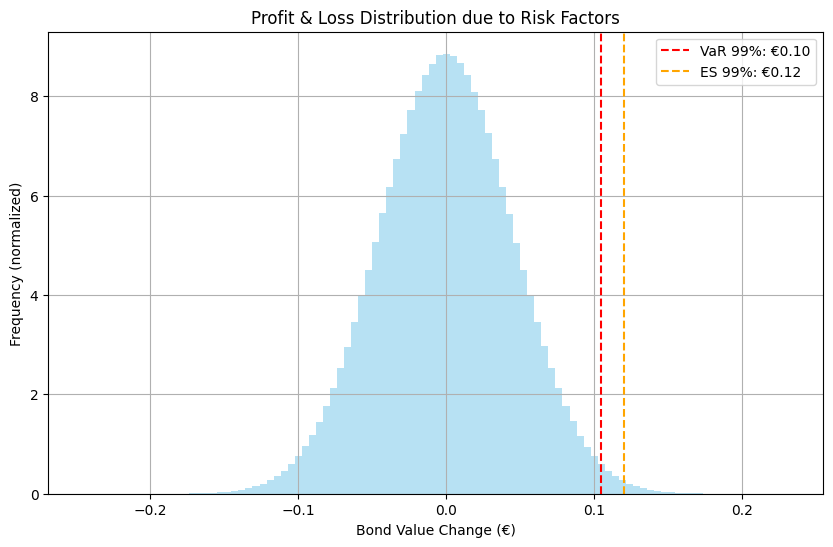

In [7]:
n_simulations = 10000000
confidence_level = 0.99

# Variance of each factor 
var_level = 0.022
var_slope = 0.003
var_curve = 0.001
var_cds = 0.002

# Standard deviations
sigma_level = np.sqrt(var_level)
sigma_slope = np.sqrt(var_slope)
sigma_curve = np.sqrt(var_curve)
sigma_cds = np.sqrt(var_cds)

# Betas from dv01
beta_level = df_dv01.loc[df_dv01["Shifts"] == "Parallel", "DV01 Shift (€)"].values[0]
beta_slope = df_dv01.loc[df_dv01["Shifts"] == "Slope", "DV01 Shift (€)"].values[0]
beta_curve = df_dv01.loc[df_dv01["Shifts"] == "Convexity", "DV01 Shift (€)"].values[0]
beta_cds = float(cds_df.loc[cds_df["CDS DV01 (€)"] != "", "CDS DV01 (€)"].values[0]) 

# Simulate factor shocks
np.random.seed(1234)
dL = np.random.normal(0, sigma_level, n_simulations)
dS = np.random.normal(0, sigma_slope, n_simulations)
dC = np.random.normal(0, sigma_curve, n_simulations)
dCDS = np.random.normal(0, sigma_cds, n_simulations)

#  P&L Sim
delta_gp = beta_level * dL + beta_slope * dS + beta_curve * dC + beta_cds * dCDS

mcs_var_99 = -np.percentile(delta_gp, 1)
mcs_es_99 = -delta_gp[delta_gp <= -mcs_var_99].mean()

# Exact formula for VaR and ES
variances = np.array([var_level, var_slope, var_curve, var_cds])
betas = np.array([beta_level, beta_slope, beta_curve, beta_cds])
sigma_gp = np.sqrt(np.sum(betas**2 * variances))
var_99 = -norm.ppf(1-confidence_level) * sigma_gp
es_99 = norm.pdf(norm.ppf(1-confidence_level)) / (1-confidence_level) * sigma_gp

# Marginal and Component VaR from MCS
factor_names = ['Level', 'Slope', 'Curvature', 'CDS']
factor_shocks = np.vstack([dL, dS, dC, dCDS])
var_index = np.argmin(np.abs(delta_gp - mcs_var_99))
var_factor_shocks = factor_shocks[:, var_index]

component_var = betas * var_factor_shocks
marginal_var = component_var / betas

print(f" MCS 99% VaR: €{mcs_var_99:.6f}")
print(f" MCS 99% ES: €{mcs_es_99:.6f}")
print(f"\n Exact 99% VaR: {var_99:.6f}")
print(f" Exact 99% ES:  {es_99:.6f}")

var_df = pd.DataFrame({
    "Factor": factor_names,
    "Beta": betas,
    "Marginal VaR (€)": marginal_var,
    "Component VaR (€)": component_var,
})
display(var_df)

plt.figure(figsize=(10,6))
plt.hist(delta_gp, bins=100, alpha=0.6, color='skyblue', density=True)
plt.axvline(mcs_var_99, color='red', linestyle='--', label=f'VaR 99%: €{mcs_var_99:.2f}')
plt.axvline(mcs_es_99, color='orange', linestyle='--', label=f'ES 99%: €{mcs_es_99:.2f}')
plt.title("Profit & Loss Distribution due to Risk Factors")
plt.xlabel("Bond Value Change (€)")
plt.ylabel("Frequency (normalized)")
plt.legend()
plt.grid(True)
plt.show()